# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* [Model architecture](Model-Training.ipynb)
* Traversal strategies
    * [Layout traversal](Traversal-Layout.ipynb)
    * Text aggregation
    * [Form extraction and validation](Traversal-Form.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Token classification traversal and feedback
We have a trained starter model, let's set `online learning` feedback loop.

Some of it could be done with the help of our pdf source. Some will require human involvement.
Our initial training data probability threshold was somewhat arbitrary due to label-matching wasn't certain.
Now we have a trained model opinion to support the decision on the right label.
Human opinion will only be needed in unresolved cases, number of which expected go down with iterations.

The model focused on a single character, but we gave it the awareness of surroundings, it reads up to 3 consecutive characters with a main focus on the middle one. In the case of failure due to the bounding box extraction failure our setup allows the model scan through the nearby context: our agent can "peer into" problematic spots.

(This notebook is only concerned with text reading and aggregation within the line.)

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from IPython.display import display, clear_output
from scipy.stats import mode
from pathlib import Path
#from unidecode import unidecode
from time import sleep

In [2]:
from scripts.extract import *
from scripts.traversal import *

In [3]:
samples = trainset + testset
len(samples)

8516

In [4]:
processed = [str(x)[len('data/feedback/'):-(len('.csv.gz'))] for x in Path('./data/feedback').glob('*.csv.gz')]
samples = [x for x in samples if not x in processed]

In [5]:
source = np.random.choice(samples)

In [6]:
print(source)
image = load_image(source)
#Image.fromarray(image)

irs-f5472-2


In [7]:
# extract features
tokens, words, lines, boxes, _ = extract_layout(image)

### Batch inference

In [8]:
class ReaderDataset(Dataset):
    def __init__(self, image, tokens, dim=32):
        self.d = dim
        self.tokens = tokens
        self.image = 255 - image
        
    def __len__(self):
        return len(self.tokens)
    
    @staticmethod
    def get_input_view(image, x, y, w, h, tag):
        if tag == 'concept':
            return square_clip(image, x - 1, y - 2, w + 2, h + 4)/255.
        d = h//4 if tag == 'target' else 2 * h//3
        s = max(w + d * 2, h + d)
        dx, dy = (s - w)//2, (s - h)//2
        return square_clip(image, x - dx, y - dy, s, s)/255.
    
    @staticmethod
    def transform(view, d):
        return torch.Tensor(cv2.resize(view, (d, d), cv2.INTER_AREA)).view(1, d, d)

    def __getitem__(self, idx):
        x, y, w, h = self.tokens.iloc[idx][BOX].values
        return [self.transform(self.get_input_view(self.image, x, y, w, h, tag), self.d)
                for tag in ['concept','target','context']]
    

In [9]:
#reader = get_readers(source='frozen')
reader = get_readers(source='online')
reader.tags

['concept', 'target', 'context']

In [10]:
def get_consensus(r):
    """
    Take the one with most votes, otherwise `context` has priority
    """
    v = r.values
    m = mode(v[:3])
    if m.count > 1:
        return INDEX[m.mode]
    if v[3] in v[:3]:
        return INDEX[v[3]]
    return ''


In [11]:
@torch.no_grad()
def batch_read(reader, image, tokens, batch_size=128):
    assert len(tokens) > 0
    
    reader.eval()

    Y, P = [], []
    # identify tokens with models consensus
    for X in DataLoader(ReaderDataset(image, tokens), batch_size=batch_size, shuffle=False):
        output = reader([x.to(DEVICE) for x in X])
        P.append(torch.t(torch.stack([torch.amax(torch.softmax(o, dim=1), dim=1)
                                      for o in output])).cpu().numpy())
        Y.append(torch.t(torch.stack([torch.argmax(torch.softmax(o, dim=1), dim=1)
                                      for o in output])).cpu().numpy())

    P = pd.DataFrame(np.vstack(P), columns=reader.keys)
    Y = pd.DataFrame(np.vstack(Y), columns=reader.keys)
    assert len(Y) == len(tokens)
    
    tokens['proba'] = P.iloc[:,:3].mean(axis=1)
    tokens['label'] = Y.apply(get_consensus, axis=1)
    
    for c in ['concept','target','context','left','right']:
        Y[c] = Y[c].apply(lambda x:INDEX[x])
    Y['semantic'] = Y['semantic'].apply(lambda x:'mhtse'[x])
    Y['orientation'] = Y['orientation'].apply(lambda x:[0, 90, 180, 270][x])
    # reader stats for analysis
    return Y, P


In [12]:
Y, P = batch_read(reader, image, tokens)

In [13]:
Y.head()

,concept,target,context,semantic,orientation,left,right
0,œ,#,A,m,180,,E
1,A,A,A,h,0,,d
2,d,d,d,m,0,,e
3,d,d,d,m,0,n,i
4,i,i,i,m,0,d,i


In [14]:
P.describe().iloc[1:,:].style.background_gradient()

,concept,target,context,semantic,orientation,left,right
mean,0.968090,0.947413,0.976065,0.993394,0.996604,0.296295,0.324563
std,0.100754,0.110154,0.084880,0.045114,0.028704,0.176455,0.166005
min,0.243315,0.178542,0.202850,0.446570,0.298005,0.073247,0.091038
25%,0.990014,0.959394,0.993920,0.999481,0.999848,0.179262,0.212985
50%,0.996723,0.991755,0.998773,0.999897,0.999961,0.243680,0.274939
75%,0.999262,0.997949,0.999630,0.999977,0.999982,0.347436,0.375078
max,0.999981,0.999956,0.999987,1.000000,0.999996,0.965153,0.997636


In [15]:
# high certainty
pd.DataFrame(tokens[tokens['label']!='']['proba'].describe()).iloc[1:].style.background_gradient('Greens')

,proba
mean,0.968488
std,0.061109
min,0.566415
25%,0.975959
50%,0.993062
75%,0.997580
max,0.999947


In [16]:
# misses
pd.DataFrame(tokens[tokens['label']=='']['proba'].describe()).iloc[1:].style.background_gradient('Reds')

,proba
mean,0.592682
std,0.094992
min,0.364968
25%,0.516629
50%,0.594804
75%,0.650442
max,0.806569


In [17]:
threshold = tokens[tokens['label']=='']['proba'].max()

### Text-aggregation traversal

In [18]:
def aggregate_text(tokens, words, lines, labels, proba, proba_threshold=0):
    """
    Do not rely on extractor but go by visual: add spaces if detected
    """
    lines['text'] = None
    words['text'] = None
    indexer = ['word-index','line-index']
    stats, word, text = [], [], []        
    last_wi, last_li = tokens.iloc[0][indexer].values
    for i in range(len(tokens)):
        V, Y, P = tokens.iloc[i], labels.iloc[i], proba.iloc[i]
        x, y, w, h = V[BOX].values
        # layout hierarchy indexers
        wi, li = V[indexer].values
        # classifications
        if Y['semantic'] == 'e' and P['semantic'] >= proba_threshold:
            continue
        
        label = '☹' if V['proba'] < proba_threshold else str(V['label'])
        
        # extractor hit `end-word`
        if wi != last_wi:
            # aggregate as extracted
            words.loc[last_wi,'text'] = ''.join(word)
            word = []
            last_wi = wi
            
        # extractor hit `end-line`
        if li != last_li:
            # aggregate as detected and remove redundant spaces
            lines.loc[last_li,'text'] = ' '.join((''.join(text)).split())
            text = []
            last_li = li

        # add space if precedes
        if Y['semantic'] in 'hs' and P['semantic'] >= proba_threshold:
            text.append(' ')
        #elif Y['left'] == ' ' and P['left'] >= proba_threshold:
        #    text.append('_')
        
        word.append(label)
        text.append(label)
        
        # add space if follows
        if Y['semantic'] in 'ts' and P['semantic'] >= proba_threshold:
            text.append(' ')
        #elif Y['right'] == ' ' and P['right'] >= proba_threshold:
        #    text.append('_')
        
    lines.loc[last_li,'text'] = ' '.join((''.join(text)).split())


In [19]:
#aggregate_text(tokens, words, lines, Y, P, proba_threshold=threshold)
aggregate_text(tokens, words, lines, Y, P, proba_threshold=0)

In [20]:
words

,left,top,width,height,block-index,line-index,text
0,149,201,187,46,0,0,
1,386,207,207,40,0,1,Additional
2,600,207,247,40,0,1,Information.
3,851,207,52,40,0,1,All
4,910,207,173,40,0,1,reporting
...,...,...,...,...,...,...,...
739,223,159,72,28,18,113,5472
740,296,159,72,28,18,113,(Rev.
741,371,159,123,28,18,113,12-2022)
742,2291,154,74,37,20,114,Page


In [21]:
lines

,left,top,width,height,block-index,text
0,149,201,196,46,0,
1,374,207,1414,40,0,Additional Information. All reporting corporat...
2,2249,257,124,37,1,☐ No
3,2084,257,136,37,1,☐ Yes
4,257,266,1126,31,1,Does the repoing corporation impo goods from a...
...,...,...,...,...,...,...
110,257,2713,376,28,6,Reserved for future use
111,158,2716,67,25,6,53
112,2020,2787,394,34,17,Form m 5472 (Rev. 12-2022)
113,136,159,367,28,18,Form m 5472 (Rev. 12-2022)


In [22]:
round(len(tokens[tokens['label']==''])/len(tokens), 2)

0.01

In [23]:
# red vs. training
len(tokens[tokens['label']!='']), len(pd.read_csv(f'./data/training/{source}.csv.gz'))

(3846, 2794)

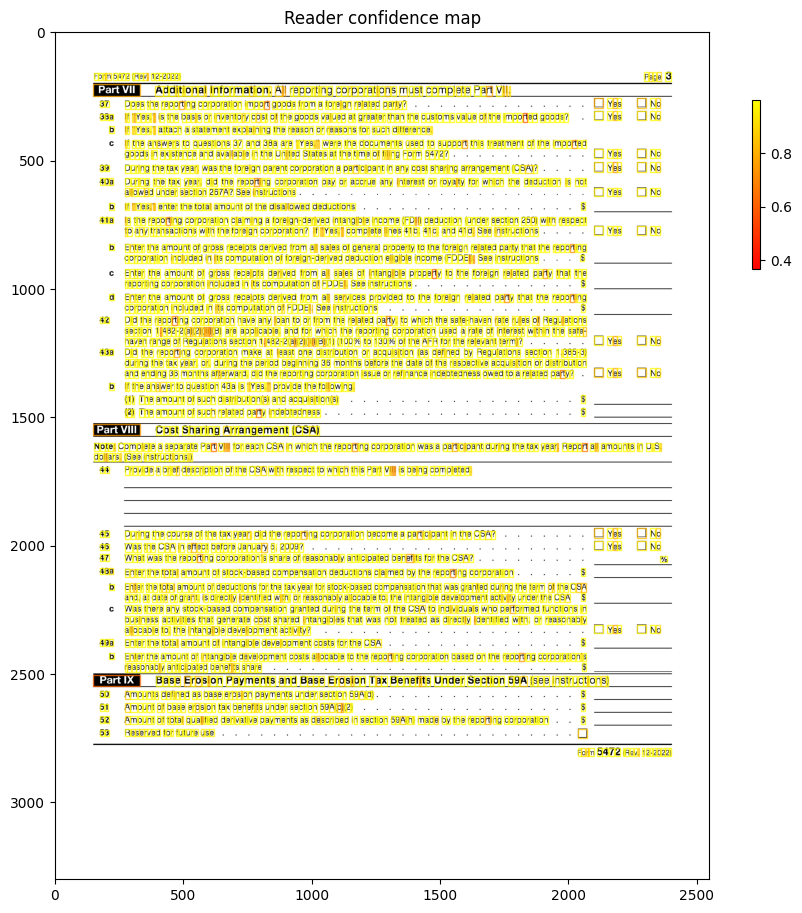

In [24]:
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(image, 'gray')
for x, y, w, h, l, p in tokens[BOX + ['label','proba']].values:
    color = plt.cm.autumn(p)
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none', alpha=0.75))
pic = ax.scatter(tokens['left'].values, tokens['top'].values, c=tokens['proba'].values, s=0, cmap='autumn')
fig.colorbar(pic, ax=ax, location='right', anchor=(0, 0.9), shrink=0.2)
plt.title(f'Reader confidence map')
plt.show()

### Gather feedback

In [25]:
def parse_sequence(tokens, proba_threshold=0):
    """
    Use actual sequence to set neighbor-labels where the model has high certainty
    """
    neighbors = tokens[['line-index','word-index']].copy()
    neighbors['left-side'] = [' '] + tokens['label'].to_list()[:-1]
    neighbors['left-li'] = [None] + tokens['line-index'].to_list()[:-1]
    neighbors['left-wi'] = [None] + tokens['word-index'].to_list()[:-1]
    neighbors['left-p'] = [0] + tokens['proba'].to_list()[:-1]
    neighbors.loc[neighbors['left-li'] != neighbors['line-index'],'left-side'] = ' '
    neighbors.loc[neighbors['left-wi'] != neighbors['word-index'],'left-side'] = ' '
    neighbors.loc[neighbors['left-p'] < proba_threshold,'left-side'] = ''
    neighbors['right-side'] = tokens['label'].to_list()[1:] + [' ']
    neighbors['right-li'] = tokens['line-index'].to_list()[1:] + [None]
    neighbors['right-wi'] = tokens['word-index'].to_list()[1:] + [None]
    neighbors['right-p'] = tokens['proba'].to_list()[1:] + [0]
    neighbors.loc[neighbors['right-li'] != neighbors['line-index'],'right-side'] = ' '
    neighbors.loc[neighbors['right-wi'] != neighbors['word-index'],'right-side'] = ' '
    neighbors.loc[neighbors['right-p'] < proba_threshold,'right-side'] = ''
    return neighbors.loc[:,['left-side','right-side']]


neighbors = parse_sequence(tokens)
neighbors.head(10)

,left-side,right-side
0,,
1,,d
2,A,d
3,d,i
4,d,t
5,i,i
6,t,o
7,i,n
8,o,a
9,n,l


In [26]:
def get_match(search, tok, threshold):
    """
    match labels from pdf and compare with reader-models
    """
    x, y, w, h = tok[BOX].values
    d, j = search.query([(y + h//2, x + w//2)], k=1)
    obj = chars.iloc[j[0][0]]
    p = estimate_proba(tok, obj)
    proba = 1. if tok['label'] == obj['label'] else tok['proba']
    return tok['label'], proba, j[0][0]


def get_feedback(tokens, image, words, chars, threshold=0.75):    
    search = KDTree(chars[['top','left']].values + chars[['height','width']].values//2)
    neighbors = parse_sequence(tokens, threshold)
    output = []
    for i in range(len(tokens)):
        tok = tokens.iloc[i]
        label, proba, index = get_match(search, tok, threshold)
        miss = None
        if proba == 1.: # check if neighbors match
            left, right = get_neighbors(index, chars)
            miss = int(left != neighbors.iloc[i,0]) + int(right != neighbors.iloc[i,1])
            neighbors.iloc[i,:] = [left, right]
        output.append({'label':label, 'proba':proba, 'miss-sides':miss })
    output = pd.DataFrame.from_dict(output).set_index(tokens.index)
    return pd.concat([output, neighbors], axis=1)


In [27]:
def get_feedback_visual(tokens, image, words, chars, threshold=0., manual=True, dim=128):
    search = KDTree(chars[['top','left']].values + chars[['height','width']].values//2)
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)

    output, neighbors = [], parse_sequence(tokens, threshold)
    for i in range(len(tokens)):
        tok = tokens.iloc[i]
        x, y, w, h = tok[BOX].values
        
        X, Y = max(0, x + w//2 - dim//2), max(0, y + h//2 - dim//2)
        ax.cla()
        ax.imshow(image[Y:Y + dim,X:X + dim], 'gray')
        ax.axvline(x=x + w//2 - X, linestyle=':')
        ax.axhline(y=y + h//2 - Y, linestyle=':')
        ax.set_xticks([i * 25 for i in range(1, dim//25)])
        ax.set_xticklabels([X + i * 25 for i in range(1, dim//25)])
        ax.set_yticks([i * 25 for i in range(1, dim//25)])
        ax.set_yticklabels([Y + i * 25 for i in range(1, dim//25)])        

        label, proba, j = get_match(search, tok, threshold)
        left, right = get_neighbors(j, chars)

        output.append({'label':label, 'proba':proba, 'miss-sides':None })
            
        # make a focus-window
        ax.add_patch(patches.Rectangle((0, 0), x - X, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X + w, 0), dim - x + X - w, dim,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X, 0), w, y - Y,
                                       alpha=0.9, edgecolor='none', facecolor='white'))
        ax.add_patch(patches.Rectangle((x - X, y - Y + h), w, y - Y + h * 2,
                                       alpha=0.9, edgecolor='none', facecolor='white'))            
        ax.add_patch(patches.Rectangle((x - X, y - Y), w, h,
                                       linewidth=1, edgecolor='C3', facecolor='none'))
        xj, yj, wj, hj = chars.iloc[j][BOX]
        ax.add_patch(patches.Rectangle((xj - X, yj - Y), wj, hj,
                                       linewidth=1, edgecolor='C2', facecolor='none'))
        title = f'  Match: {left:>2}[{label:<1}]{right:<2} {proba:<8.0%} Done {(i + 1)/len(tokens):.2%}'
        ax.set_title(title, fontsize=10, loc='left', fontname='monospace')
        display(fig)
        clear_output(wait=True)
        
        if manual:
            label = input().strip() or label
            proba = 1.
            if label == '-1':
                proba = 0.
            if label == '##':
                break

        output.append({'label':label, 'proba':proba })
    output = pd.DataFrame.from_dict(output).set_index(tokens.index)
    return pd.concat([output, neighbors], axis=1)


#### Auto-run

In [28]:
# extract features
tokens, words, lines, boxes, _ = extract_layout(image)
Y, P = batch_read(reader, image, tokens)
wlabels, chars, inputs = load_labels(source, int(tokens[tokens['label']!='']['height'].median()))

In [29]:
len(tokens[tokens['label']==''])

46

In [30]:
auto = get_feedback(tokens, image, wlabels, chars, threshold=threshold)
#auto = get_feedback_visual(tokens, image, wlabels, chars, threshold=threshold, manual=False)

In [31]:
# trusted feedback
round(len(tokens[auto['proba']==1.])/len(tokens), 2)

0.95

In [32]:
# trusted samples count vs. training data
len(tokens[auto['proba']==1.]), len(pd.read_csv(f'./data/training/{source}.csv.gz'))

(3689, 2794)

In [33]:
# require feedback
len(tokens[tokens['label']==''])

46

In [34]:
aggregate_text(tokens, words, lines, Y, P, proba_threshold=threshold)

#### Human feedback
Let's make sure we do not have any artifacts in our training data.

In [35]:
len(tokens[tokens['label']==''])

46

    # show reference for setting labels (if need copy-paste)
    print(' '.join(INDEX))

    manual = get_feedback_visual(tokens[tokens['label']==''], image, wlabels, chars)

    columns = ['label','proba','left-side','right-side'] 
    tokens.loc[tokens['label']=='', columns] = manual[columns].values
    len(tokens[tokens['label']==''])

    # pick trusted and manual
    selection = (manual['label']!='')|(auto['proba'] == 1.)
    # save for training
    tokens[tokens['proba'] == 1.].to_csv(f'./data/feedback/{source}.csv.gz', index=False, compression='gzip')

After we've done with manual corrections

    !jupyter nbconvert --to notebook --execute Model-Feedback.ipynb

and trained the model on this feedback we can run some auto-feedback.

### Training with auto-feedback
Low `proba` along with low number of trusted samples (in particular if number of trusted samples is less than the number of initial training samples) signals "dirty" labels. We run training with feedback data in iterations and incremental model updates, so, we could figure out that trend, make correction if needed, and stay on the safe side.

    reader = get_readers(source='online')
    
    # clear previous feedback (generated for the older model)
    !rm data/feedback/*.csv.gz
    
    for k in range(2): # run k iterations
        
        # gather outcome stats
        stats, skip, count, updated, samples = [], 0, 0, 0, trainset + testset
        for i, source in enumerate(np.random.choice(samples, len(samples), replace=False), 1):
            image = load_image(source)    
            tokens, words, lines, boxes, _ = extract_layout(image)
            if len(tokens) == 0:
                stats.append([source, 0, 1, 0, 0, 0, 0])
                skip += 1
                continue
            Y, P = batch_read(reader, image, tokens)
            p = P['context'].median()
            threshold = tokens[tokens['label']=='']['proba'].max()
            if p < threshold: # filter out samples where the model has low certainty
                stats.append([source, p, 1, 0, len(tokens), N, 0])
                skip += 1
                continue            
            N = len(pd.read_csv(f'./data/training/{source}.csv.gz')) # training samples number
            words, chars, inputs = load_labels(source, int(tokens[tokens['label']!='']['height'].median()))
            auto = get_feedback(tokens, image, words, chars, threshold=threshold)
            miss = auto.loc[auto['proba']==1.,'miss-sides'].dropna().sum()
            stats.append([source, p, 0, len(tokens[auto['proba']==1.]), len(tokens), N, miss])
            tokens = tokens.loc[auto['proba']==1.]
            columns = ['label','proba','left-side','right-side']
            tokens.loc[:,columns] = auto.loc[auto['proba']==1.,columns].values
            print(f'done: {i/len(samples):<7.2%} skipped: {skip/i:<7.2%} updates: {updated}', end='\r')
            if len(tokens) < N: # take only samples where more current trusted than in initial training
                stats[-1][2] = 1
                skip += 1
                continue
            tokens.to_csv(f'./data/feedback/{source}.csv.gz', index=False, compression='gzip')
            count += 1
            # update model using 10% of samples
            if count >= len(samples)//10:
                # train 10 epochs on feedback data
                print(f'done: {i/len(samples):<7.2%} skipped: {skip/i:.2%}  training...    ')

                !jupyter nbconvert --to notebook --execute Model-Feedback.ipynb
                !rm data/feedback/*.csv.gz

                count, updated = 0, updated + 1

        # save iteration stats
        columns = ['source','proba','skipped','trusted','total','training','miss']
        stats = pd.DataFrame(stats, columns=columns).set_index('source')
        stats.to_csv(f'./data/auto-feedback-{k + 1}.csv')
        
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        (stats['skipped'].rolling(1000).sum().dropna()/1000).plot(ax=ax[0][0])
        ax[0][0].set_title('skip-rate timeline')
        (stats['trusted']/stats['training']).rolling(1000).mean().dropna().plot(ax=ax[0][1])
        ax[0][1].set_title('trusted over training timeline')
        stats['proba'].rolling(1000).mean().dropna().plot(ax=ax[1][0])
        ax[1][0].set_title('sample `proba` timeline')
        (stats['trusted']/stats['total']).rolling(1000).mean().dropna().plot(ax=ax[1][1])
        ax[1][1].set_title('trusted over total timeline')
        for i, a in enumerate(ax.flatten()):
            a.set_xticks([])
            a.set_xlabel('order')
            a.tick_params(axis='both', which='major', labelsize=8)
        plt.show()